In [6]:
# ============================================================
# 📦 STEP 0. MOUNT GOOGLE DRIVE
# ============================================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [33]:
# ============================================================
# 1️⃣ Dataset
# ============================================================
dataset_path = "/content/drive/MyDrive/rempah_dataset"

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224,224),
    batch_size=32,
    subset='training',
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(224,224),
    batch_size=32,
    subset='validation',
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)
print("Jumlah kelas:", num_classes)
print("Label kelas:", train_generator.class_indices)


Found 1680 images belonging to 10 classes.
Found 420 images belonging to 10 classes.
Jumlah kelas: 10
Label kelas: {'biji ketumbar': 0, 'cengkeh': 1, 'jahe': 2, 'kayu manis': 3, 'kemiri': 4, 'kencur': 5, 'kunyit': 6, 'lada': 7, 'lengkuas': 8, 'serai': 9}


In [34]:
# ============================================================
# 2️⃣ Model Transfer Learning (MobileNetV2)
# ============================================================
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze layer awal

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [35]:

# ============================================================
# 3️⃣ Callback & Training
# ============================================================
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/model_rempah_v3.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1887 - loss: 2.4424
Epoch 1: val_accuracy improved from -inf to 0.64524, saving model to /content/drive/MyDrive/model_rempah_v3.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.1906 - loss: 2.4362 - val_accuracy: 0.6452 - val_loss: 1.3293 - learning_rate: 1.0000e-04
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5496 - loss: 1.3471
Epoch 2: val_accuracy improved from 0.64524 to 0.75238, saving model to /content/drive/MyDrive/model_rempah_v3.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.5506 - loss: 1.3450 - val_accuracy: 0.7524 - val_loss: 0.9244 - learning_rate: 1.0000e-04
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6756 - loss: 0.9971
Epoch 3: val_accuracy improved from 0.75238 to 0.81905, saving model to /content/drive/MyDrive/model_rempah_v3.keras
53/53 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.6759 - loss: 0.9961 - val_accuracy: 0.8190 - val_loss: 0.7255

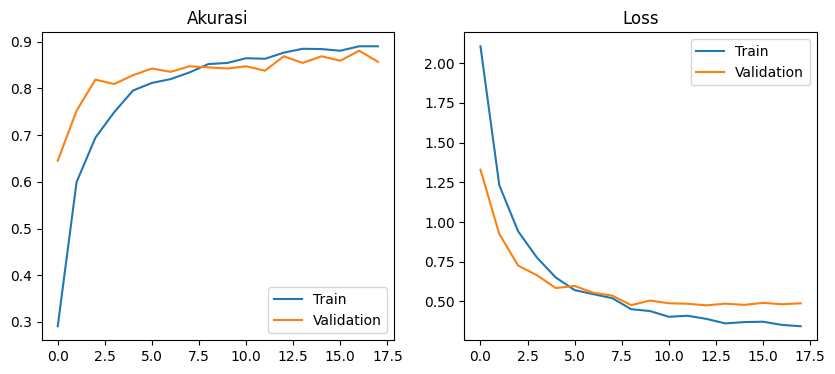

In [36]:
# ============================================================
# 4️⃣ Plot Akurasi & Loss
# ============================================================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Akurasi")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
✅ Prediksi: kunyit (99.90% yakin)


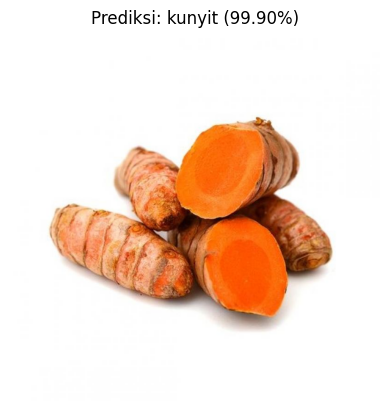

In [42]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Muat model terbaik
model = load_model("/content/drive/MyDrive/model_rempah_v3.keras")

# Path gambar yang ingin diuji
image_path = "/content/drive/MyDrive/kunyit1.jpg"

# Preprocessing
img = load_img(image_path, target_size=(224,224))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
pred = model.predict(img_array)
class_indices = train_generator.class_indices
class_labels = list(class_indices.keys())

predicted_class = class_labels[np.argmax(pred)]
confidence = np.max(pred)

print(f"✅ Prediksi: {predicted_class} ({confidence*100:.2f}% yakin)")

plt.imshow(load_img(image_path))
plt.title(f"Prediksi: {predicted_class} ({confidence*100:.2f}%)")
plt.axis("off")
plt.show()
